In [1]:
import os
import random
from matplotlib import axis
import scipy.io as sio
import numpy as np
import pandas as pd 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
import joblib
import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import KFold, train_test_split
import model as dl  # Ensure this module contains necessary utility functions
import logging
from mne.preprocessing import ICA
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用 GPU
seed = 34
dl.seed_everything(seed)
# EEG data parameters
duration = 2500

from itertools import combinations

# 初始脑区定义
regions = {
    "prefrontal": [0, 1, 2, 3, 10, 11, 16],
    "central": [4, 5, 17],
    "temporal": [12, 13, 14, 15],
    "parietal": [6, 7, 18],
    "occipital": [8, 9]
}

# 自动生成多脑区组合
def generate_combinations(regions, sizes):
    combined_regions = {}
    region_names = list(regions.keys())

    # 遍历指定组合大小
    for size in sizes:
        for combination in combinations(region_names, size):
            combined_name = "_".join(combination)  # 组合名称
            combined_indices = sorted(set().union(*(regions[region] for region in combination)))  # 合并去重
            combined_regions[combined_name] = combined_indices

    return combined_regions

# 生成所有二、三、四脑区组合
regions = generate_combinations(regions, sizes=[1,2, 3, 4,5])
# 动态获取变量值
partition = "prefrontal_central_temporal_parietal_occipital"

In [4]:
def importAndCropData(file_paths, duration, labels,partition):
    EEG_list = []
    for i, file in enumerate(file_paths):
        try:
            raw =pd.read_csv(file)
            data = np.array(raw)[:,1:]
            data = data[partition]
            channels = len(partition)
            feature = data.shape[1]
            data_new = data.reshape(1, channels, feature)
            EEG_list.append(data_new)
            logging.info(f"Processed file {file} done")
        except Exception as e:
            logging.error(f"Error processing file {file}: {e}")
            continue

    if not EEG_list:
        raise ValueError("No data was loaded. Please check the file paths and formats.")
    EEG = np.concatenate(EEG_list)
    logging.info(f"Total epochs: {EEG.shape[0]}, Normal: {np.sum(labels == 1)}, "
            f"MCI: {np.sum(labels == 0)}")
    return EEG

In [5]:
import os
import warnings
# 忽略 RuntimeWarning 警告
warnings.filterwarnings("ignore", category=RuntimeWarning)
# 定义文件夹路径
base_dir = '伊朗特征'
normal_dir = os.path.join(base_dir, '认知正常\\频域\\PSD')
impaired_dir = os.path.join(base_dir, '认知障碍\\频域\\PSD')

# 获取所有的文件路径
normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.csv')]
impaired_files = [os.path.join(impaired_dir, f) for f in os.listdir(impaired_dir) if f.endswith('.csv')]

all_files = normal_files + impaired_files
labels = np.concatenate([np.zeros(len(normal_files)),np.ones(len(impaired_files))],axis=0)
# 将 all_files 和 label_single 中的元素按相同顺序打乱
combined = list(zip(all_files, labels))
random.shuffle(combined)
all_files[:], labels[:] = zip(*combined)


all_data = importAndCropData(all_files, duration,labels,regions["prefrontal_central_temporal_parietal_occipital"])


2024-12-23 14:30:20,077 - INFO - Processed file 伊朗特征\认知正常\频域\PSD\17_96.csv done
2024-12-23 14:30:20,080 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\7_268.csv done
2024-12-23 14:30:20,083 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\25_327.csv done
2024-12-23 14:30:20,087 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\2_286.csv done
2024-12-23 14:30:20,090 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\9_242.csv done
2024-12-23 14:30:20,096 - INFO - Processed file 伊朗特征\认知正常\频域\PSD\16_110.csv done
2024-12-23 14:30:20,100 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\23_180.csv done
2024-12-23 14:30:20,105 - INFO - Processed file 伊朗特征\认知正常\频域\PSD\1_342.csv done
2024-12-23 14:30:20,108 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\7_131.csv done
2024-12-23 14:30:20,111 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\2_71.csv done
2024-12-23 14:30:20,115 - INFO - Processed file 伊朗特征\认知障碍\频域\PSD\2_261.csv done
2024-12-23 14:30:20,127 - INFO - Processed file 伊朗特征\认知正常\频域\PSD\16_360.csv done
2024-12-23 14:30:20,130 - INFO - Proc

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
X_flattened = all_data.reshape(all_data.shape[0], -1)
y = labels  # 使用相同的标签

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=1)

# 计算各项指标

from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # 计算各个指标
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # 等同于 sensitivity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = precision_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision
    }


# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 创建SVM分类器
svm_classifier = SVC(kernel='linear')  # 使用线性核
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(np.concat([X_train,X_test],axis=0))


# MLP
# mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=300, alpha=1e-4,
#                 solver='adam', verbose=10, random_state=999,
#                 learning_rate_init=.001)
# mlp.fit(X_train, y_train)
# y_pred = mlp.predict(X_test) 



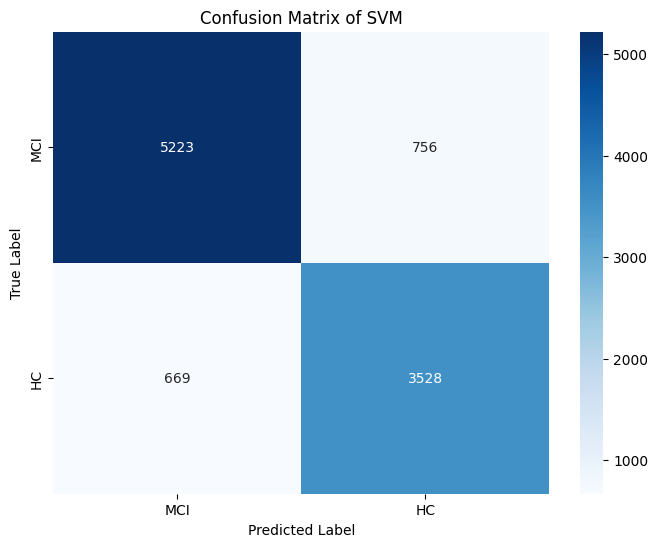

accuracy: 0.8600
kappa: 0.7120
sensitivity: 0.8406
specificity: 0.8736
precision: 0.8235


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix of SVM'):
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 创建热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # 设置标题和标签
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # 计算各个指标
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # 等同于 sensitivity
    specificity = confusion_matrix(y_true, y_pred).ravel()
    if len(specificity) == 4:
        TN, FP, FN, TP = specificity
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    else:
        specificity = 0
    precision = precision_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision
    }

# 示例用法
if __name__ == "__main__":
    # 假设的数据
    # 绘制混淆矩阵图
    classes = ['MCI', 'HC']  # 类别名称
    plot_confusion_matrix(np.concat([y_train,y_test],axis=0), y_pred, classes)

    # 打印评估指标
    metrics = calculate_metrics(np.concat([y_train,y_test],axis=0), y_pred)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")